# Read in the data

In [50]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [51]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [52]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [53]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [54]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [55]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [56]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [57]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [58]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [59]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [60]:
#create a dataset of correlations and survey columns
survey_correlations = correlations[survey_fields]
survey_correlations = survey_correlations.reset_index()

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


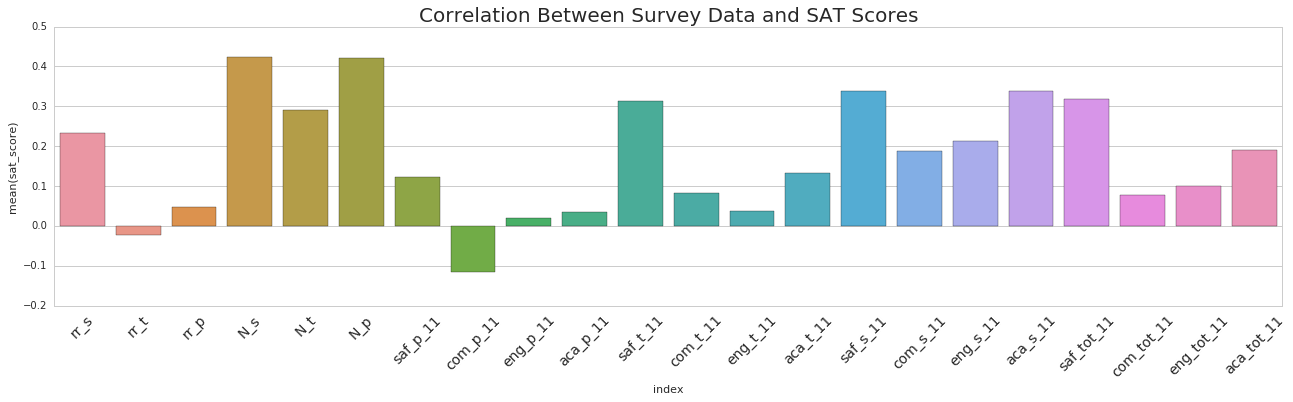

In [61]:
#Run matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize = (22,5))
sns.barplot(data = survey_correlations, x='index', y='sat_score')
plt.xticks(fontsize=14, rotation=45)
plt.title('Correlation Between Survey Data and SAT Scores', fontsize=20)
plt.show()

From the chart we can see that there are some survey questions with correlations to SAT scores. 

#### We should first investigate:
N_s
N_p

From the data dictionary (https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) we can see that these refer to the Number of STUDENTS and Number of PARENTS. This suggests that higher populated schools see better SAT scores. 

#### Additionally, there is correlation for 
saf_t_11
saf_s_11
saf_tot_11

These refer to Safety & Respect score from teachers/Students & totals. This indicates that schools where both teachers and students feel SAFE and RESPECTED will acheive higher SAT scores


#### Finally, we see correlation in 
aca_s_11
Academic Expectations scores from students. This indicates that in schools where students expect high expectations we should also see high SAT scores



# Investigating Safety Scores

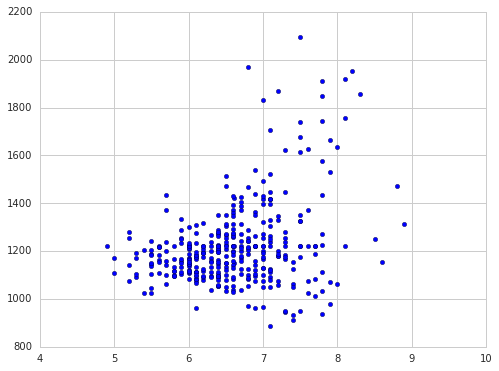

In [62]:
#plot the saf_s_11 vs sat score
plt.figure(figsize=(8,6))
plt.scatter(data = combined, x='saf_s_11', y='sat_score')
plt.show()

We can see that there is a loose, positive relationship between the safety score and SAT scores. This generally indicates safety influences SAT scores, but not as strongly as you might expect.

In [63]:
#Compute the mean safety scores for each bourough
safety_district = combined.groupby('school_dist')['saf_s_11'].agg(np.mean)
print(safety_district)

school_dist
01    6.768611
02    6.910660
03    6.716667
04    6.885714
05    6.314286
06    6.950000
07    6.800000
08    6.364697
09    6.655000
10    6.577273
11    6.186667
12    7.116667
13    6.407692
14    6.685714
15    6.177778
16    5.875000
17    6.007143
18    6.190909
19    6.150000
20    7.120000
21    6.390909
22    7.025000
23    6.233333
24    7.107692
25    6.912500
26    6.760000
27    6.390000
28    6.627273
29    6.075000
30    7.033333
31    6.530000
32    6.766667
Name: saf_s_11, dtype: float64


# Investigating Race
the data contains columns for race percentage of students. Is there a correlation between race and SAT Scores?


In [64]:
#get the race columns
raceFields = ["white_per", "asian_per", "black_per", "hispanic_per"]
raceCorrelations = correlations[raceFields]
raceCorrelations = raceCorrelations.reset_index()

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


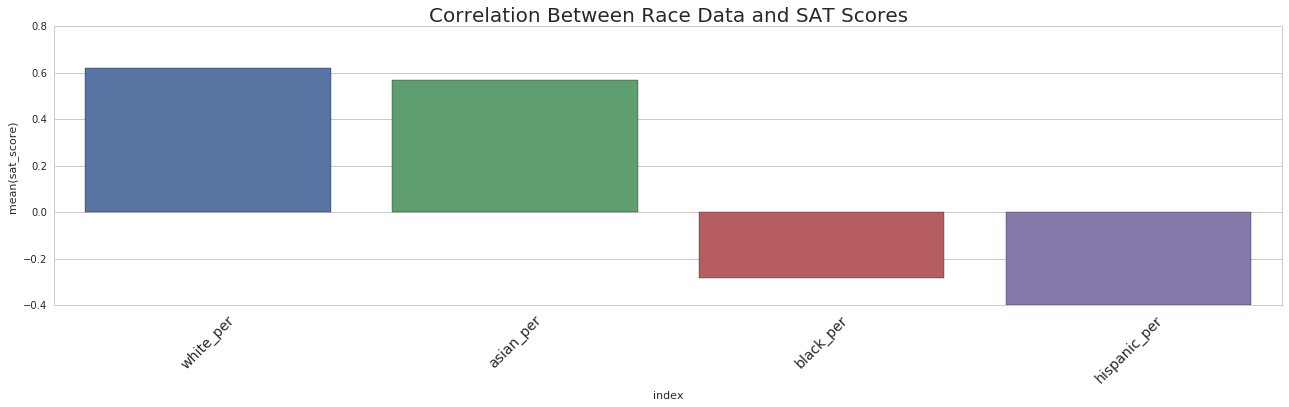

In [65]:
#Plot the race correlations to SAT
sns.set_style("whitegrid")
plt.figure(figsize = (22,5))
sns.barplot(data = raceCorrelations, x='index', y='sat_score')
plt.xticks(fontsize=14, rotation=45)
plt.title('Correlation Between Race Data and SAT Scores', fontsize=20)
plt.show()

We see then that there is a correlation between schools with high white & asian student percentages and higher SAT scores. Conversely there is a negative correlation between schools with black/hispanic percentages and lower SAT scores

# Investigate the Low SAT Scores and Hispanic Race Data

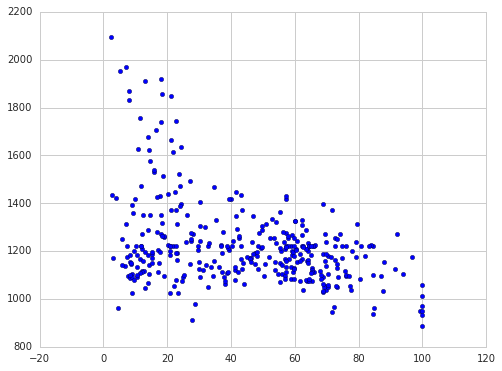

In [67]:
#plot the hispanic_per vs sat score
plt.figure(figsize=(8,6))
plt.scatter(data = combined, x='hispanic_per', y='sat_score')
plt.show()

Plotting the SAT Scores vs hispanic percentage we can see that there is a negative relationship between these two fields. As the percentage of hispanic students grows, the SAT scores decrease

# Investigating Gender
Similarly, the data contains percentages of male/female gender identities. Is there a correlation to SAT scores?

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


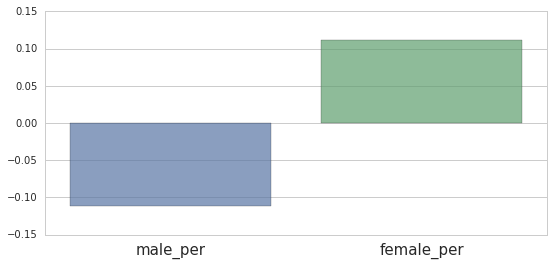

In [75]:
# plot the correlation between male and female percentages and SAT score
gender_corr = correlations.loc[['male_per', 'female_per']]
plt.figure(figsize=(9,4))
sns.barplot(gender_corr.index, gender_corr.values, alpha=0.7)
plt.xticks(fontsize=15)
plt.show()

The correl values are very slight, but do seem to indicate schools with higher percentage female students may score higher on SAT scores. 

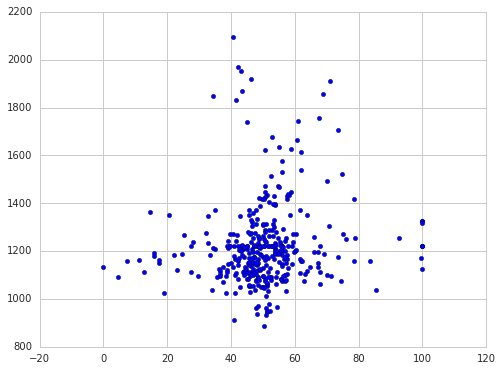

In [76]:
#plot the female_per vs sat score
plt.figure(figsize=(8,6))
plt.scatter(data = combined, x='female_per', y='sat_score')
plt.show()

When we further investigate we can see that there is not really an evident relationship between female percentage and SAT scores. 

# Investigating AP scores
Let's compare schools that had a high numbert of students take AP exams to see if that improves a school's overall SAT Scores

Rather than use enrollment as the baseline (which we know is correlated to SAT scores), we can find the proportion of those students that took AP exams

In [77]:
#Calculate percentage of students who took AP exams
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

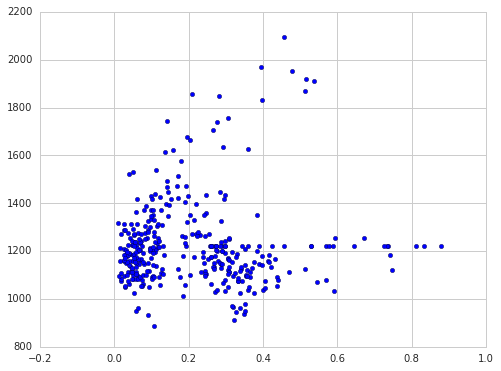

In [78]:
#plot the SAT scores vs ap percentage
plt.figure(figsize=(8,6))
plt.scatter(data = combined, x='ap_per', y='sat_score')
plt.show()

We see that there appears to be a positive correlation in some cases, but that is not always the case. While we might assume that more students taking AP tests might indicate better overall SAT scores, the relationship is marginal at best. 